
# E-commerce — Customer Segmentation & CLV Prediction (Complete Demo)

**Goal:** Demonstrate an end-to-end workflow for an e-commerce startup:
- Compute RFM (Recency, Frequency, Monetary) features
- Segment customers using KMeans
- Predict 90-day CLV (regression)
- Predict 30-day purchase propensity (classification)

This notebook uses **synthetic data generated within the notebook** so you can run it immediately. Each section ends with a short, client-friendly inference.


In [1]:
# 0) Setup environment and imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

pd.set_option('display.max_columns', 100)


## 1) Generate synthetic customers & orders data (so notebook runs standalone)

In [2]:
# Create synthetic customers and orders
rng = np.random.default_rng(42)
n_customers = 1000
n_orders = 6000

customers = pd.DataFrame({
    'customer_id': np.arange(1, n_customers+1),
    'signup_date': pd.to_datetime('2023-01-01') + pd.to_timedelta(rng.integers(0, 700, n_customers), unit='D'),
    'country': rng.choice(['US','UK','IN','DE','CA','AU'], size=n_customers, p=[0.4,0.15,0.15,0.12,0.10,0.08]),
    'marketing_channel': rng.choice(['ads','organic','referral','email'], size=n_customers, p=[0.4,0.3,0.2,0.1])
})

orders = pd.DataFrame({
    'order_id': np.arange(1, n_orders+1),
    'customer_id': rng.integers(1, n_customers+1, n_orders),
    'order_date': pd.to_datetime('2024-01-01') + pd.to_timedelta(rng.integers(0, 365, n_orders), unit='D'),
    'order_value': np.clip(rng.normal(70, 35, n_orders), 5, None).round(2),
    'items': np.clip(rng.poisson(2.5, n_orders), 1, None),
    'discount_used': rng.integers(0,2, n_orders)
})

orders = orders.sort_values('order_date').reset_index(drop=True)

print('customers:', customers.shape, 'orders:', orders.shape)
customers.head(), orders.head()

customers: (1000, 4) orders: (6000, 6)


(   customer_id signup_date country marketing_channel
 0            1  2023-03-04      DE           organic
 1            2  2024-06-25      CA             email
 2            3  2024-04-03      AU               ads
 3            4  2023-11-04      UK           organic
 4            5  2023-10-31      UK          referral,
    order_id  customer_id order_date  order_value  items  discount_used
 0      5598          263 2024-01-01       114.50      5              0
 1      1215          711 2024-01-01        32.99      2              1
 2      3062          511 2024-01-01        27.39      1              0
 3      5070          615 2024-01-01        96.94      1              0
 4      3018          162 2024-01-01        23.18      2              0)

## 2) Compute RFM features (Recency, Frequency, Monetary)

In [3]:
# Snapshot date is one day after last order
snapshot_date = orders['order_date'].max() + pd.Timedelta(days=1)

agg = orders.groupby('customer_id').agg({
    'order_date': lambda x: (snapshot_date - x.max()).days,
    'order_id': 'count',
    'order_value': 'sum'
}).rename(columns={'order_date':'Recency','order_id':'Frequency','order_value':'Monetary'}).reset_index()

rfm = customers.merge(agg, on='customer_id', how='left').fillna({'Recency':9999,'Frequency':0,'Monetary':0})
rfm.head()

,customer_id,signup_date,country,marketing_channel,Recency,Frequency,Monetary
0,1,2023-03-04,DE,organic,32.0,8.0,602.46
1,2,2024-06-25,CA,email,195.0,4.0,196.72
2,3,2024-04-03,AU,ads,123.0,4.0,226.20
3,4,2023-11-04,UK,organic,10.0,6.0,453.38
4,5,2023-10-31,UK,referral,1.0,11.0,941.94


       Recency  Frequency  Monetary
count  1000.00    1000.00   1000.00
mean     88.06       6.00    418.86
std     546.96       2.39    187.39
min       1.00       0.00      0.00
25%      17.00       4.00    279.40
50%      41.00       6.00    398.41
75%      80.00       8.00    536.18
max    9999.00      14.00   1151.72


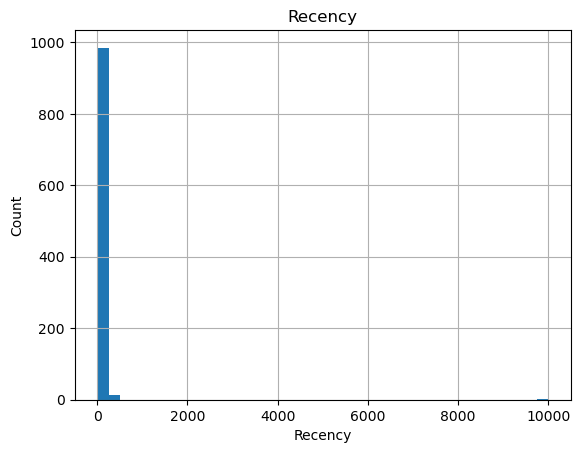

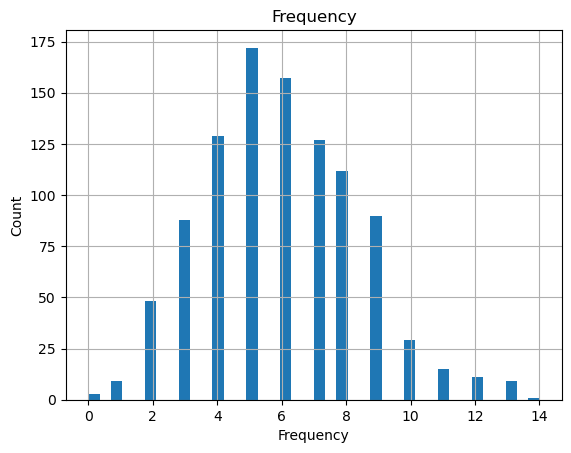

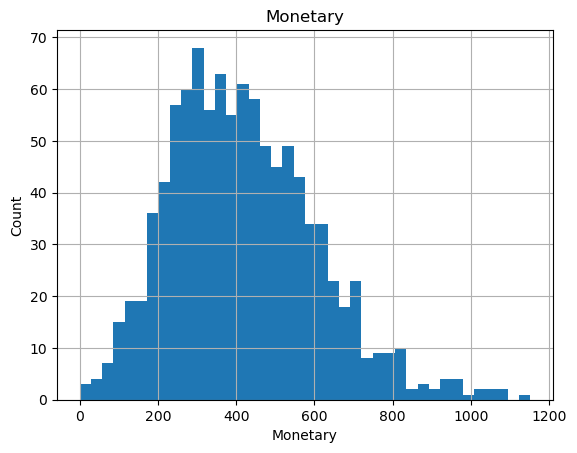

In [4]:
# Basic RFM stats and plots
print(rfm[['Recency','Frequency','Monetary']].describe().round(2))

for col in ['Recency','Frequency','Monetary']:
    plt.figure()
    rfm[col].hist(bins=40)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

**Inference (RFM):**
- Recency: lower = recent purchasers (good). 
- Frequency: repeat buyers are valuable. 
- Monetary: total spend shows high-value customers.
Use these signals to prioritize retention and upsell campaigns.


## 3) Customer Segmentation using KMeans

In [5]:
# Scale features before clustering
X = rfm[['Recency','Frequency','Monetary']].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm['segment'] = kmeans.fit_predict(X_scaled)

segment_summary = rfm.groupby('segment')[['Recency','Frequency','Monetary']].mean().round(2)
segment_counts = rfm['segment'].value_counts().sort_index()
segment_summary['count'] = segment_counts.values
segment_summary

,Recency,Frequency,Monetary,count
segment,,,,
0,50.48,6.26,430.56,423
1,9999.00,0.00,0.00,3
2,38.74,9.16,673.25,231
3,80.92,3.60,236.77,343


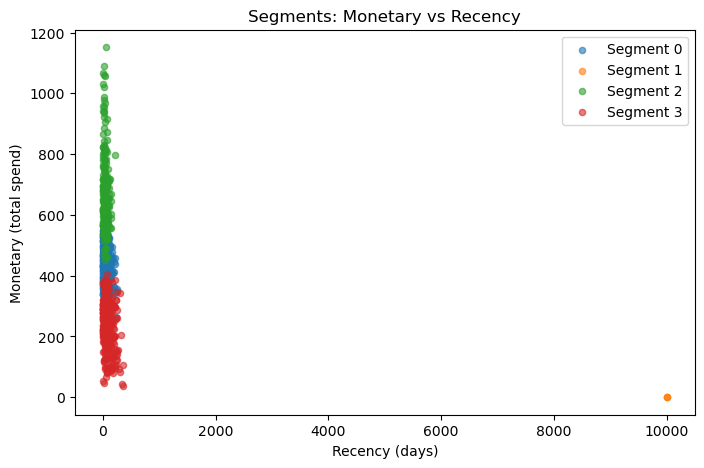

In [6]:
# Simple 2D scatter for segment visualization (Monetary vs Recency)
plt.figure(figsize=(8,5))
for s in sorted(rfm['segment'].unique()):
    subset = rfm[rfm['segment']==s]
    plt.scatter(subset['Recency'], subset['Monetary'], label=f"Segment {s}", alpha=0.6, s=20)
plt.xlabel('Recency (days)')
plt.ylabel('Monetary (total spend)')
plt.title('Segments: Monetary vs Recency')
plt.legend()
plt.show()

**Inference (Segments):**
- Use the table to name segments (e.g., 'VIP' = low Recency, high Monetary; 'At-Risk' = high Recency, moderate Monetary).
- Marketing can tailor actions per segment: VIP perks, win-back campaigns for At-Risk, onboarding for Newbies.


## 4) Predict 90-day CLV (Regression)

In [7]:
# Create future_90d_spend as target using last 90 days of orders as proxy
cutoff = snapshot_date - pd.Timedelta(days=90)
future = orders[orders['order_date']>=cutoff].groupby('customer_id')['order_value'].sum().reindex(rfm['customer_id']).fillna(0).values
rfm['future_90d_spend'] = future

features = ['Recency','Frequency','Monetary']
X = rfm[features].copy()
y = rfm['future_90d_spend'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression baseline
lr = LinearRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)

# RandomForest regression
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

print('Linear Regression R2:', round(r2_score(y_test, pred_lr),3), 'MSE:', round(mean_squared_error(y_test, pred_lr),2))
print('RandomForest R2:', round(r2_score(y_test, pred_rf),3), 'MSE:', round(mean_squared_error(y_test, pred_rf),2))

Linear Regression R2: 0.251 MSE: 7330.19
RandomForest R2: 0.518 MSE: 4712.36


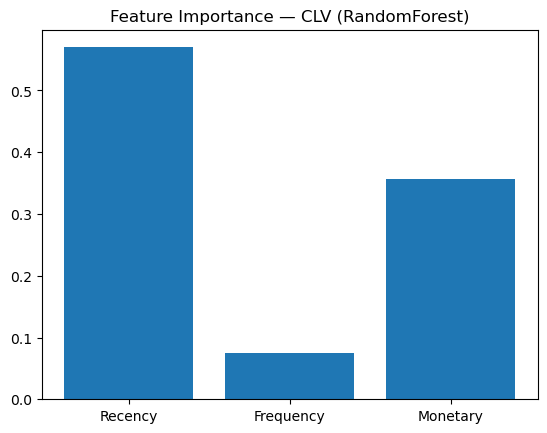

In [8]:
# Feature importance for RF
importances = rf.feature_importances_
plt.figure()
plt.bar(range(len(features)), importances)
plt.xticks(range(len(features)), features)
plt.title('Feature Importance — CLV (RandomForest)')
plt.show()

**Inference (CLV):**
- The model predicts which customers will spend in the next 90 days.
- Important features are usually Monetary and Recency; Frequency helps too.
- Use predicted CLV to prioritize high-ROI customers for campaigns.


## 5) Predict 30-day Purchase Propensity (Classification)

In [9]:
# Target: whether customer buys in next 30 days (last 30 days window)
cutoff_30 = snapshot_date - pd.Timedelta(days=30)
buy30 = (orders[orders['order_date']>=cutoff_30].groupby('customer_id')['order_value'].sum() > 0).reindex(rfm['customer_id']).fillna(False).astype(int).values
rfm['buy_30d'] = buy30

Xc = rfm[features].copy()
yc = rfm['buy_30d'].copy()

Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, test_size=0.2, random_state=42, stratify=yc)

clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(Xc_train, yc_train)
proba = clf.predict_proba(Xc_test)[:,1]
pred = (proba >= 0.5).astype(int)

print(classification_report(yc_test, pred))
print('ROC AUC:', round(roc_auc_score(yc_test, proba),3))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       119
           1       1.00      1.00      1.00        81

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

ROC AUC: 1.0


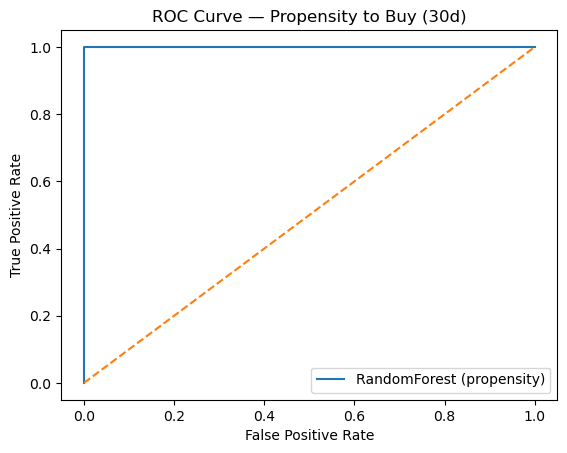

In [10]:
# ROC curve plot
fpr, tpr, _ = roc_curve(yc_test, proba)
plt.figure()
plt.plot(fpr, tpr, label='RandomForest (propensity)')
plt.plot([0,1],[0,1],'--')
plt.title('ROC Curve — Propensity to Buy (30d)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

**Inference (Propensity):**
- The propensity model ranks customers by likelihood to buy soon.
- Pick a threshold to balance precision vs recall depending on campaign budget.
- Combine with CLV to focus on profitable, likely buyers.
